# Lab 4 - Principal component analysis

In this lab we will discuss Principle Component Analysis. By the end of this lab you should be able to:

- Compute and visualise the priciple componenets of 1D data set with two variables using basic matrix algebra;
- Load and interogate a 2D sea surface temperature field using xarray;
- Compute the priciple components of a 1D slice of the 2D times series.

First we go through the basics of PCA with the table one of Wilks data.

**`GeoData.jl` very unhelpfully (from a timing point of view) changed to `Rasters.jl` so have to change a few things...**

Will have to change this at some point but I think I can get away with `GeoData.jl` for now. 
The custom dimensions also unhelpfully stopped working...

In [20]:
using Pkg
Pkg.activate("..")
using Plots, Statistics, Glob, Dates, GeoData, NCDatasets, LinearAlgebra, CSV, Suppressor, DataFrames, DimensionalData

  Activating environment at `~/Documents/GitHub/MATH5271/Project.toml`


In [3]:
table1 = CSV.File("Wilks_TableA1.csv")
tab1 = DataFrame(table1);

## Basics of PCAs

Consider a data set with $n$ observations of K anomaly (mean = 0) variables 
$$X = \begin{bmatrix}\bf{x}_{1} & \bf{x}_{2} & ... & \bf{x}_{K}
\end{bmatrix}\\
=\begin{bmatrix}x_{11} & x_{12} & ... & x_{1K}\\
x_{21} & x_{22} & ... & x_{2K}\\
... & ... & ... & ...\\
x_{n1} & x_{n2} & ... & x_{nK}
\end{bmatrix}\\
$$

The 1st principle component $\bf{u}_1$ is the linear combination of the K variables that gives the largest variance. For it to be a linear combination we need to find the unit vector ${\bf e}_1$ such that 

$${\bf{u}}_1 ={\bf e}_{1}^{\text{T}}{\bf x}_k = \sum_{k=1}^K e_{k1}{\bf x}_k.$$

Let's use the Ithaca minimum temperature anomaly as $\bf{x}_{1}$ and Canandaigua as $\bf{x}_{2}$ to illustrate how this works.

In this case we have $K=2$, $n= 31$, $x_{11}$ is the Ithica minimum temperature on the 1st of January etc.

First lets compute these and display a scatter plot

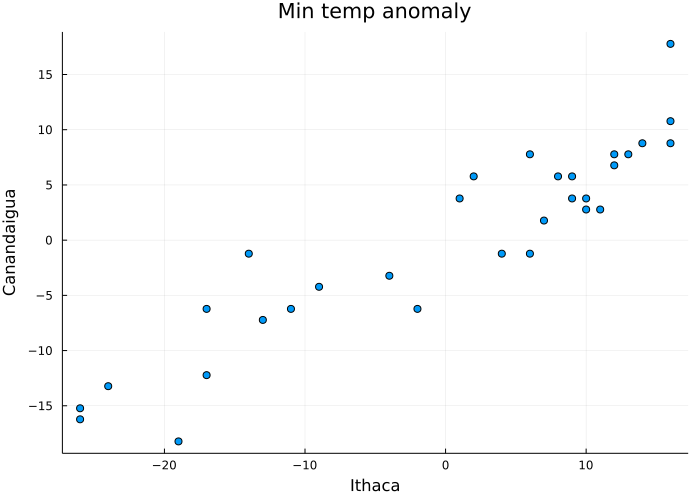

In [6]:
mintemp = tab1[:, "MinTemp_Far"]
find = findall(tab1[:, :Location] .== "Ithaca")
Ithaca = mintemp[find] .- mean(mintemp[find])
find = findall(tab1[:, :Location] .== "Canandaigua")
Can = mintemp[find] .- mean(mintemp[find])

scatter(Ithaca, Can, xlabel = "Ithaca", ylabel = "Canandaigua", label = false, title = "Min temp anomaly", size = (700, 500))

## Covariance matrix and eigenvalues

Hardcode the covariance matrix then calculate the eigenvalues which are the principal components.

In [25]:
n = length(Ithaca)
S = (1/(n-1)) .* [sum(Ithaca.^2) sum(Ithaca.*Can); sum(Ithaca.*Can) sum(Can.^2)]
println(S)
Scov = cov([Ithaca Can])
println(Scov)

[185.46666666666667 110.80000000000001; 110.80000000000001 77.58064516129032]
[185.46666666666667 110.80000000000001; 110.80000000000001 77.58064516129032]


In [26]:
PCs = eigen(Scov)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
   8.290184774581327
 254.75712705337565
vectors:
2×2 Matrix{Float64}:
  0.530222  -0.847859
 -0.847859  -0.530222

The first pair of numbers are the eigenvalues ($\lambda$) and remaining array is our eigenvectors (E). Notice that the first and largest eigenvalue corresponds very closely to the variance and the eigenvector corresponds to the vector we found earlier and they are exactly as in Wilks.

So the eigenvectors of the covariance matrix identify the direction of greatest co-variance in our data and the eigenvalues identify the magnitude of that co-variance.

The eigenvvalues are given lowest to highest so for use in julia want to start at the last eigenvalue and the last eigenvector.

I think this means that to look at the first principal component is then

$$
u_{1} = \mathbf{e}_{1}^{T}\mathbf{x} = 0.85x_{1} + 0.53x_{2}
$$

though julia has computed negative eigenvalues.
Not sure why this is but as you can see below that it does not (unsurprisingly) make a difference.

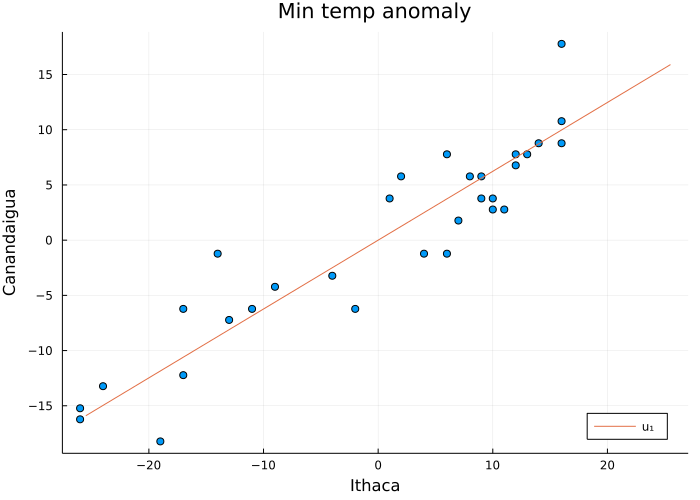

In [30]:
scatter(Ithaca, Can, xlabel = "Ithaca", ylabel = "Canandaigua", label = false, title = "Min temp anomaly", size = (700, 500))
plot!(-0.85.*(-30:30), -0.53.*(-30:30), label = "u₁", legend = :bottomright)

Can see here that by finding the principal component the original data is the recreated using the values over which the data ranges.

I think this is the best intro to this as can clearly see how the principal component captures the behaviour.
Need to get my head around what happens in the higher dimensions though this will no doubt come.

## One dimensional SST reconstrcution from principal components

From the `SSTglobal` data we want to generate the anomaly.
This is computed in a simialr to the `xarray` package by taking the `mean` over the time dimension using the `GeoData.jl` package.

There is more info for this in task two.

In [21]:
SST_datapath = joinpath("../..", "globalSST/sst")
globalSST_data = glob("*.nc", SST_datapath)
globalSST_file = NCDataset(globalSST_data; aggdim = "time")

NCDataset: ../../globalSST/sst/NOAA_NCDC_ERSST_v3b_SST-1960.nc…../../globalSST/sst/NOAA_NCDC_ERSST_v3b_SST-2016.nc
Group: /

Dimensions
   lat = 89
   lon = 180
   time = 684

Variables
  lat   (89)
    Datatype:    Float32
    Dimensions:  lat
    Attributes:
     _FillValue           = NaN
     standard_name        = latitude
     pointwidth           = 2.0
     gridtype             = 0
     units                = degree_north

  lon   (180)
    Datatype:    Float32
    Dimensions:  lon
    Attributes:
     _FillValue           = NaN
     standard_name        = longitude
     pointwidth           = 2.0
     gridtype             = 1
     units                = degree_east

  sst   (180 × 89 × 684)
    Datatype:    Float32
    Dimensions:  lon × lat × time
    Attributes:
     _FillValue           = -999.0
     pointwidth           = 1.0
     valid_min            = -3.0
     valid_max            = 45.0
     units                = degree_Celsius
     long_name            = Extended reco

In [57]:
#lat = globalSST_file["lat"][:]
#lon = globalSST_file["lon"][:]
timelength =  globalSST_file["time"][:]
sst =  globalSST_file["sst"]

plotargs = (xlabel = "Longitude (degrees east)", ylabel = "Latitude (degrees north)")

#Create custom dimension types
#@dim Lon YDim "Longitude (degrees north)"
#@dim Lat XDim "Latitude (degrees east)"
#Create vectors that are the same size as the latitude and longitude in the data.
#I needed to do this because these arrays were being read as unordered categorical which could then not be plotted.
lon = 0:2:358
lat = -88:2:88
dimensions = (X(lon), Y(lat), Ti(timelength))

X 0:2:358,
Y -88:2:88,
Ti DateTime[1960-01-15T00:00:00, …, 2016-12-15T00:00:00]

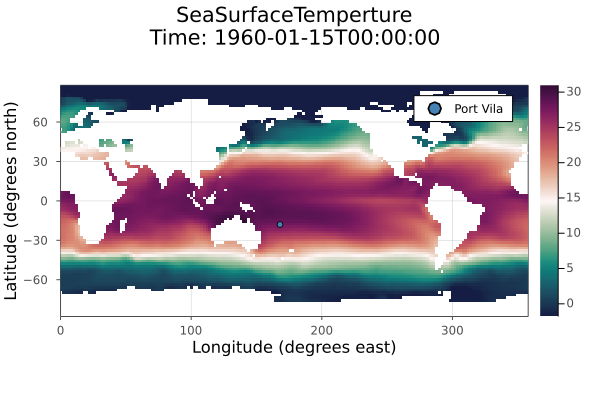

In [52]:
#SSTglobal = GeoArray(sst, dimensions, name = :SeaSurfaceTemperture)
SSTglobal = GeoArray(sst, dimensions, name = :SeaSurfaceTemperture)
fullplot = plot(SSTglobal[Ti(1)]; plotargs...)
portvila_lat = findall(lat .== -18)
portvila_lon = findall(lon .== 168)
van_coords = (lon[portvila_lon], lat[portvila_lat])
scatter!(fullplot, van_coords, label = "Port Vila", color = :steelblue, m =:octagon, markersize = 3)

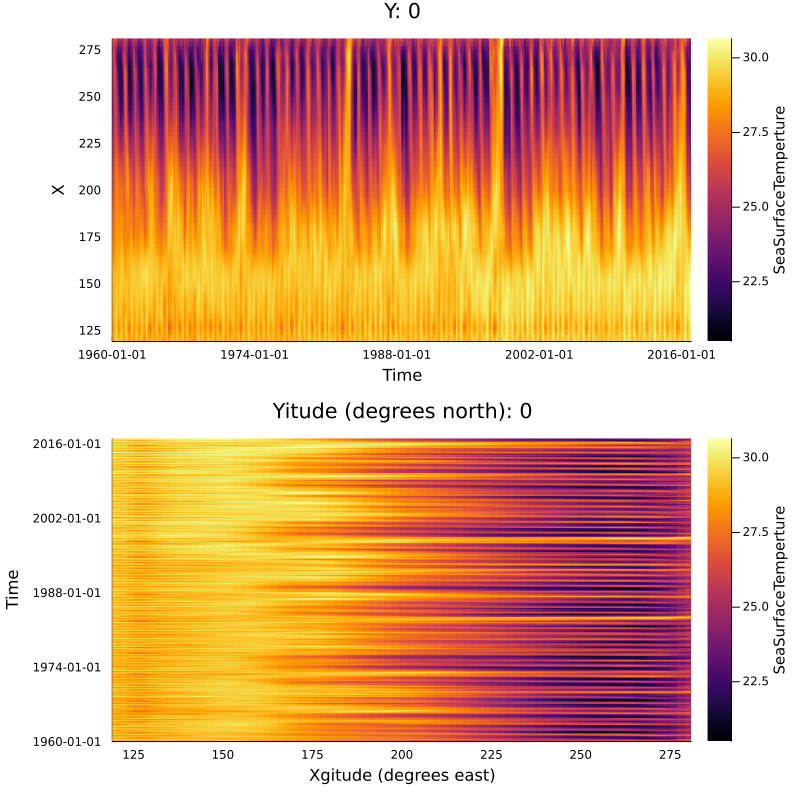

In [53]:
long_ts = SSTglobal[X(GeoData.Between(120, 280)), Y(At(0)), Ti()] 
plot1 = long_ts |> heatmap
plot2 = heatmap(120:2:280, timelength, long_ts', 
                title = "Yitude (degrees north): 0",
                xlabel = "Xgitude (degrees east)",
                ylabel = "Time",
                colorbar_title  = "SeaSurfaceTemperture")
plot(plot1, plot2, size = (800, 800), layout = (2, 1))

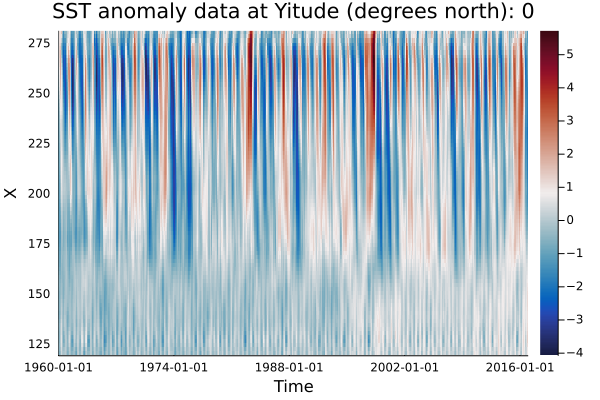

In [54]:
long_ts_mean = mean(long_ts, dims = Ti)
long_ts_mean = repeat(long_ts_mean, outer = (1, 684))
long_ts_anom = long_ts .- long_ts_mean
anom_plot = heatmap(long_ts_anom, color = :balance, title = "SST anomaly data at Yitude (degrees north): 0")

I now go through the lab 4 one dimensional reconstruction from the first principal component.
This is to both familiarise myself with the way the `GeoData.jl` package and check that I can correctly reproduce the lab 4 work before moving on to the 2D principal components.

Compute the covariance matrix and get the eigenvectors for form the principal components.
The covariance is computed for the longitude, so the dimension to get the covarince of is `Time`.

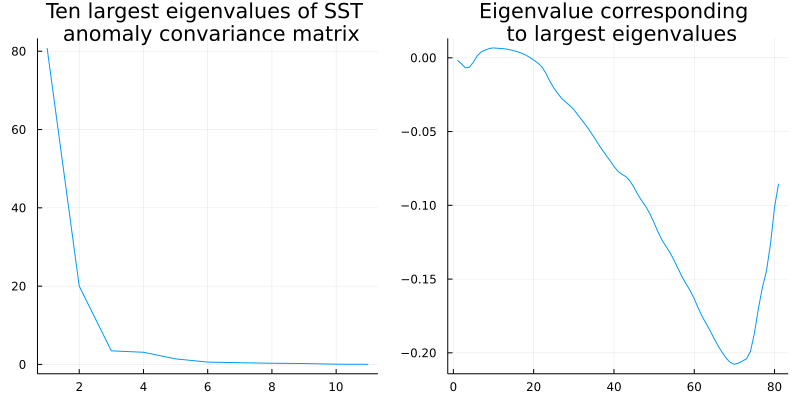

In [14]:
C_long_ts = cov(long_ts_anom, dims = Ti)
Cmat = reshape(C_long_ts[:], (81, 81)) #Turn this into a matrix to use with the `eigen` function.
Eigen_decomp_Cmat = eigen(Cmat)
plot(plot(Eigen_decomp_Cmat.values[end:-1:end-10], title = "Ten largest eigenvalues of SST \n anomaly convariance matrix", label = false),
    plot(Eigen_decomp_Cmat.vectors[:, end], title = "Eigenvalue corresponding \n to largest eigenvalues", label = false),
    layout = (1, 2), 
    size = (800, 400)
)

Now compute the first pricipal component $\mathbf{u}_{1}$.
This is done by multpliying the observations by the eigenvector corresponding to the largest eigenvalue, then summing this over the longitude dimension `X`

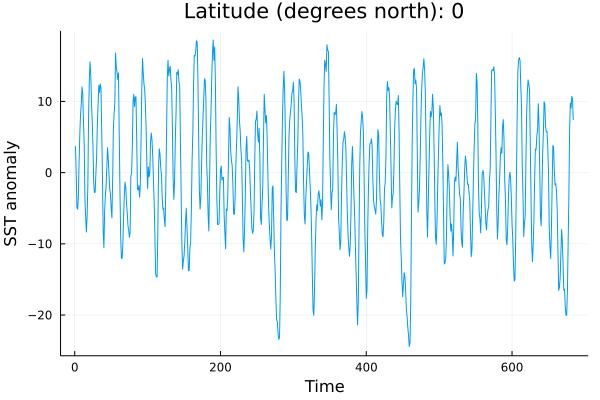

In [15]:
e₁ = Eigen_decomp_Cmat.vectors[:, end]
u₁ = sum(e₁ .* long_ts_anom; dims = X)
plot(u₁[:], label = false, xlabel = "Time", ylabel = "SST anomaly", title = "Yitude (degrees north): 0")

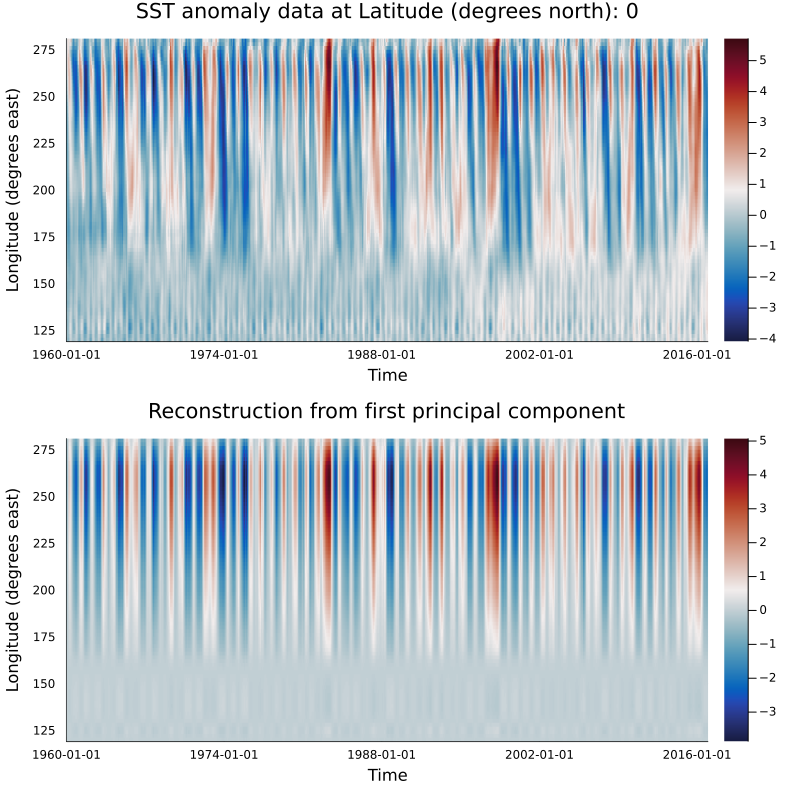

In [16]:
long_ts_anom_recon = e₁ .* u₁
long_ts_anom_recon = set(long_ts_anom_recon, X => 120:2:280) #Manually reset the number of X points to match the `long_ts_anom` data.
recon_plot = heatmap(long_ts_anom_recon, color = :balance, title = "Reconstruction from first principal component")
plot(anom_plot, recon_plot, size = (800, 800), layout = (2, 1))